# **量子コンピュータワークショップ実践編（part1）**

## **初期設定**

このページを開いたらまず始めに "Copy to Drive" をクリックしてください。\
自分の Google Drive にこのファイルがコピーされます。

コピーができたらそのファイルを開いてください。\
以降はこのコピーしたファイル上で実行を行います。

**実行方法**

プログラムにカーソルをかざすと再生ボタンが出るのでそれをクリックしたら実行されます。\
また `Shift + Enter` でも実行できます。

## **Step0 パッケージのダウンロード**

必要なパッケージがダウンロードされます。

In [1]:
# インストール
!git clone https://github.com/devel-system/QuantumAIWorkshop-20230228.git lib
!chmod +x lib/colab.sh
!lib/colab.sh

Cloning into 'lib'...
remote: Enumerating objects: 60, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 60 (delta 30), reused 47 (delta 17), pack-reused 0
Unpacking objects: 100% (60/60), 11.17 KiB | 78.00 KiB/s, done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 64.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 81.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.6/96.6 KB 9.6 MB/s eta 0:00:00
  Attempting uninstall: click
    Found existing installation: click 7.1.2
    Uninstalling click-7.1.2:
      Successfully uninstalled click-7.1.2
ERROR: pip's dependency resolver does not currentl

In [2]:
# データのインポート
import networkx as nx
from pyqubo import Binary
from neal import SimulatedAnnealingSampler
from dwave.system import DWaveSampler, EmbeddingComposite
import matplotlib.pyplot as plt
from IPython.display import IFrame

%matplotlib inline

## **Step1 古典：問題をQUBOに変換する**
今回扱う簡単な経路問題を量子アニーリングで解けるようにQUBOの式に変換します。

・入力データには量子アニーリングの設定をしています。\
`DWAVE_TOKEN` には [D-wave Leap](https://cloud.dwavesys.com/leap/) から取得したトークンを入力してください。\
（トークンを取得できなかった場合はそのままでも動きますので大丈夫です。）

`DWAVE_DEVICE_NAME` には実際に動かす量子コンピュータの名前を入力してください。\
量子コンピュータの種類は [D-wave Leap](https://cloud.dwavesys.com/leap/) の Solvers に一覧があります。

<table>
    <tr>
        <th>デバイス名</th>
        <td>Advantage_system5.3</td>
        <td>Advantage2_prototype1.1</td>
        <td>Advantage_system4.1</td>
        <td>Advantage_system6.1</td>
        <td>DW_2000Q_6</td>
    </tr>
    <tr>
        <th>量子ビット</th>
        <td>5615</td>
        <td>563</td>
        <td>5627</td>
        <td>5616</td>
        <td>2041</td>
    </tr>
    <tr>
        <th>トポロジー</th>
        <td>pegasus</td>
        <td>zephyr</td>
        <td>pegasus</td>
        <td>pegasus</td>
        <td>chimera</td>
    </tr>
</table>

・グラフデータは今回扱う問題をグラフに起こしています。

・QUBO変換では起こしたグラフを元にQUBOの式を作成しています。

QUBO
 ((1000.000000 * (((1.000000 + (-1.000000 * Binary('1->g'))) * (1.000000 + (-1.000000 * Binary('1->g')))) + ((Binary('s->1') + -1.000000) * (Binary('s->1') + -1.000000)) + (((-1.000000 * Binary('1->g')) + Binary('s->1') + (-1.000000 * Binary('1->2'))) * ((-1.000000 * Binary('1->g')) + Binary('s->1') + (-1.000000 * Binary('1->2')))))) + Binary('1->g') + Binary('s->1') + Binary('1->2'))


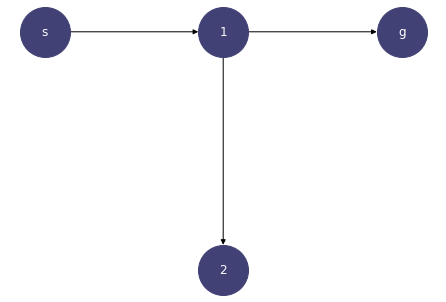

In [3]:
########################
####   入力データ    #####
########################
# アニーリング設定
weight = 1000
SHOTS = 1000
DWAVE_TOKEN=""
DWAVE_DEVICE_NAME="DW_2000Q_6"

########################
###   グラフデータ    ####
########################
G = nx.DiGraph()
G.add_edges_from([('s', 1), (1, 2), (1, 'g')])
pos = {'s':[-1, 0], 1:[0, 0], 2:[0, -1], 'g': [1, 0]}
nx.draw(G, pos=pos, node_color="#414175", node_size=2500, font_color="#fff", with_labels=True)

########################
####    QUBO変換    #####
########################
r_s1 = Binary("s->1")
r_12 = Binary("1->2")
r_1g = Binary("1->g")

QUBO_Obj = r_s1 + r_12 + r_1g
QUBO_Penalty = (r_s1 - 1) ** 2 + (r_s1 - r_12 - r_1g) ** 2 + (1 - r_1g) ** 2
QUBO = QUBO_Obj + weight * QUBO_Penalty

print("QUBO\n", QUBO)

## **Step2 量子：QUBOを元にアニーリングを行う**

DWave社の量子アニーリングを用いて QUBO の解を見つけます。

Step1で `DWAVE_TOKEN` を入力している場合は実際の量子コンピュータが動きます。入力していない場合はシミュレーションが動きます。

ここでは実行したデバイスと最終結果が表示されます。

In [4]:
########################
##   量子アニーリング    ##
########################
qubo_model = QUBO.compile()
qubo_compiled, offset = qubo_model.to_qubo()

if not DWAVE_TOKEN:
    sampler = SimulatedAnnealingSampler()
    device = "SimulatedAnnealingSampler"
else:
    REGION = "eu-central-1" if DWAVE_DEVICE_NAME == "Advantage_system5.3" else "na-west-1"
    sampler = EmbeddingComposite(DWaveSampler(region=REGION, token=DWAVE_TOKEN, solver={"name": DWAVE_DEVICE_NAME}))
    device = sampler.properties['child_properties']['chip_id'] + " (DWaveSampler)"

sampleset = sampler.sample_qubo(qubo_compiled, num_reads=SHOTS, label="Quantum Annealing Part1")
answer = sampleset.first.sample
energy = sampleset.first.energy

print("デバイス:", device)
print(f"結果\n{answer}")
print(f"Energy: {energy}")

デバイス: SimulatedAnnealingSampler
結果
{'1->2': 0, '1->g': 1, 's->1': 1}
Energy: -1998.0


## **Step3 古典：結果から答えを求める**

Step2で求めた量子アニーリングの結果から実際の経路を求めます。

経路は赤色で表示されます。

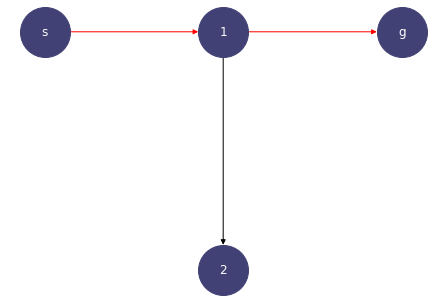

In [5]:
########################
###   グラフデータ    ####
########################
G = nx.DiGraph()
G.add_edges_from([('s', 1), (1, 2), (1, 'g')])

edge_color = []
for s, g in G.edges():
    v = answer[f'{s}->{g}']
    if v == 0:
        edge_color.append('k')
    else:
        edge_color.append('r')

pos = {'s':[-1, 0], 1:[0, 0], 2:[0, -1], 'g': [1, 0]}
nx.draw(G, pos=pos, node_color="#414175", font_color="#fff", node_size=2500, edge_color=edge_color, with_labels=True)

## **番外編 その他アニーリング検証ツール**

### blueqat社

In [ ]:
src_blueqat = 'https://qa.blueqat.com'
IFrame(src_blueqat, width='100%', height='800')

### ビネット&クラリティ社

In [ ]:
src_vigne = 'https://vigne-cla.xxxx.jp/qc2022/'
IFrame(src_vigne, width='100%', height='800')

---
## <small>教材作成</small>
<small>DEVEL株式会社</small>